In [6]:
import Pkg
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Arpack")
Pkg.add("BayesNets")
import BayesNets
import CSV
using DataFrames
using Printf
import Statistics

 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


In [7]:
#
# Load and transform data
#

load = function(filename)
    to_col_name = function(secname, number)
        return Symbol("$(String(secname))_$(@sprintf("%02d", number))")
    end
    
    data = CSV.read(filename; datarow = 1, delim = ';', quotechar = '"');
    data_meta = data[1:4, :]
    data = data[4:end, :]
    
    current_title = ""
    current_subtitle = ""
    current_framestart = 0
    items = Dict{Symbol, Array{Symbol}}()
    descriptions = Dict{Symbol, Union{Missing, String}}()
    for i in 1:size(data_meta)[2]
        if !ismissing(data_meta[1, i])
            current_title = data_meta[1, i]
            current_subtitle = ""
            current_framestart = i
        end
        if !ismissing(data_meta[2, i])
            current_subtitle = data_meta[2, i]
            current_framestart = i
        end

        secname = "$(current_title)_$(current_subtitle)"

        colname = to_col_name(secname, i - current_framestart)
        rename!(data, names(data)[i] => colname)
        descriptions[colname] = data_meta[3, i]

        if current_subtitle == "CODE" || current_subtitle == "CATEGORIES"
            if current_framestart == i
                items[Symbol(secname)] = Symbol[]
            end
            
            data[colname] = .! ismissing.(data[colname])
            push!(items[Symbol(secname)], colname)
        elseif current_subtitle == "FAILURE"
            data[colname] = data[colname] .== "1"
        end
    end
    
    return data, descriptions, items
end


params = (
    filename = "NaPiRE-project_2014_Coding.csv",
)
data, descriptions, items = load(params.filename);

Edges found: 71, average weight: 4.901408450704225
Edges found: 79, average weight: 4.69620253164557


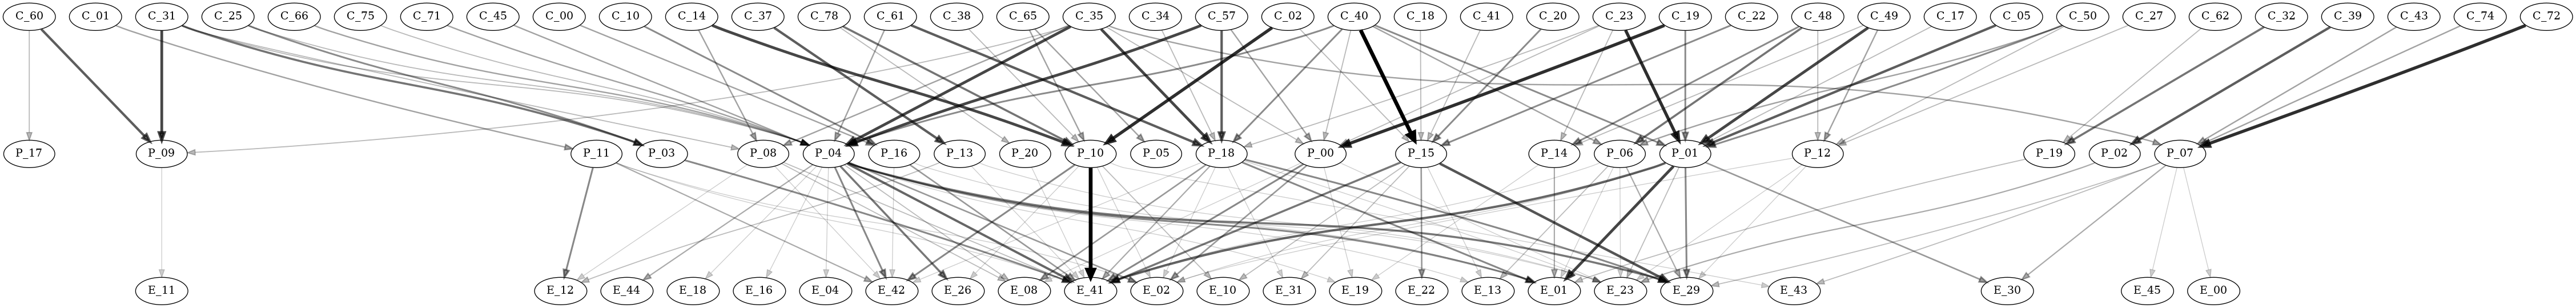

In [10]:
#
# Visualise data
#

function create_edges(from ::Symbol, to ::Symbol, filtersize ::Int64)
    edges = Dict{Pair{Symbol, Symbol}, Int64}()

    for from_node in items[from]
        for to_node in items[to]
            edges[(from_node => to_node)] = 0

            for i in 1:size(data)[1]
                if data[i, from_node] && data[i, to_node]
                    edges[(from_node => to_node)] += 1
                end
            end
        end
    end
    
    return filter((kv) -> kv.second >= filtersize, edges)
end

function gviz_start(ranksep)
    dot = "digraph out {\n"
    dot *= " graph [ranksep=\"$(ranksep)\"];"
    dot *= "\n\n"
    return dot
end

function print_edges(from ::Symbol, to ::Symbol, filtersize ::Int64)
    dot = ""
    edges = create_edges(from, to, filtersize)
    max_edges = maximum(values(edges))
    average_weight = Statistics.mean(values(edges))
    println("Edges found: $(length(edges)), average weight: $average_weight")
    
    for ((n1, n2), n_edges) in edges
        edge_weight = n_edges / max_edges
        alpha = @sprintf("%02x", round(edge_weight * 255))
        n1 = string(n1)
        n1 = n1[1:1] * n1[end-2:end]
        n2 = string(n2)
        n2 = n2[1:1] * n2[end-2:end]

        dot *= "$(n1) -> $(n2) [penwidth = $(edge_weight * params.penwidth_factor), color = \"#000000$(alpha)\"];\n"
    end
    
    return dot
end
    
function gviz_end(dot)
    dot *= "}"

    dotfile = tempname()
    pngfile = tempname()
    try
        write(dotfile, dot)
        run(`dot -o$pngfile -Tpng $dotfile`)
        return read(pngfile)
    finally
        rm(dotfile, force = true)
        rm(pngfile, force = true)
    end
end

params = (
    minimum_edge_weight = 3,
    penwidth_factor = 5,
    ranksep =  2
)
    
dot  = gviz_start(params.ranksep)
dot *= print_edges(:CAUSES_CODE, :PROBLEMS_CODE, params.minimum_edge_weight)
dot *= print_edges(:PROBLEMS_CODE, :EFFECTS_CODE, params.minimum_edge_weight)

if isdefined(Main, :IJulia) && Main.IJulia.inited
    display("image/png", gviz_end(dot))
end

In [2]:
#
# Bayesian Network
#

bayesian_network = function ()
    graph_edges = create_edges(:CAUSES_CODE, :PROBLEMS_CODE, 3)
    graph_layout = Tuple(keys(graph_edges))
    
    relevant_nodes = collect(union(Set(e.first for e in keys(graph_edges)), Set(e.second for e in keys(graph_edges))))
    println(size(relevant_nodes))
    println(size([ items[:CAUSES_CODE]; items[:PROBLEMS_CODE] ]))
    graph_data = data[:, relevant_nodes]
    graph_data = DataFrame(colwise(x -> [sum(x)], graph_data), names(graph_data))
    #graph_data = graph_data[sum(convert(Matrix, graph_data), dims = 2)[:] .> 0, :]
    
    #return graph_data
    #
    return BayesNets.fit(BayesNets.DiscreteBayesNet, graph_data, graph_layout)
end

a = bayesian_network()

UndefVarError: UndefVarError: create_edges not defined

In [1]:
println("asd")

asd
